# MACHINE LEARNING MID-TERM PROJECT

For our project, we implement multinomial regression on the given wine data set to classify the wines into three different categories. We follow the theory discussed in the following link to complete the task. https://www.geeksforgeeks.org/softmax-regression-using-tensorflow/

### STEP 0: Import the used libraries 


In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### STEP 1: Import the data.
We use numpy mostly in our code but here we have use pd.read_csv to just visualise the data.

In [109]:
wines_pd = pd.read_csv('file:///Users/dompenguin/Downloads/wine.data', names=["x","Alcohol", "Malic Acid", "Ash", "Alkalinity of ash","Magnesium","Total Phenols","Flavanoids","Nonflavanoid phenols","Proanthocyanins","Color intensity","Hue","OD280/OD315 of Diluted wines","Proline"])
wines_pd.head()

,x,Alcohol,Malic Acid,Ash,Alkalinity of ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of Diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Convert the pandas dataframe to a numpy dataframe. 

In [110]:
whole_dataframe = pd.DataFrame.to_numpy(wines_pd)

### STEP 2: Modify the dataset to make it suitable for our purposes.  
We use 50 datapoints for training and the rest for testing. Since the dataframe is sorted according to classes, we shuffle the rows and use np.random.seed(0) to fix our shuffle so that we don't get a different result everytime we run the code.

In [111]:
np.random.seed(0)
np.random.shuffle(whole_dataframe)
[training_dataframe, testing_dataframe] = np.split(whole_dataframe, [50], axis=0)

We take the classes out of our dataframe since they won't be needed <i>directly</i> in our regression process. We will define the one-hot encoded target matrix with the classes. 

In [112]:
x = np.delete(training_dataframe, 0, 1)
classes = training_dataframe[:,0]

Standardise our data and the augment it with column of ones 

In [113]:
def standardise(x):
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x
x = standardise(x)[0]

### Step 3: Define the functions/tools necessary to implement the regression. 
Make y, the one-hot encoded target matrix. It is defined as follows:
<br>For each element $i$ in the classes array (which can take value  $j$ = 1, 2 or 3), the $i^{th}$ row of y will have zeros everywhere except at its intercept with the $j^{th}$ column where it will have a one. 

In [114]:
y = np.zeros([classes.shape[0],3])
for i in range(0,classes.shape[0]):
    save = int(classes[i] - 1) 
    y[i,save] = 1

For a set of numbers $ z = (z_1,z_2,..,z_n) $, the softmax for the $i^{th}$ element is 
<br><br> $$ f(z)_i = \frac{exp(z_i)}{\sum_{k=1}^{n}{exp(z_k)}} $$ <br>  For the purpose of making our code more efficient, we get our softmax values with our function softmaxval which takes a matrix as its input and gives us a matrix of the same size with softmax values of each element relative to its row. For example, for input matrix of size 4x3 the softmaxval function will work as follows
<br>$$ softmaxval\left(\left\lbrack \begin{array}{ccc}
x_{11}  & x_{12}  & x_{13} \\
x_{21}  & x_{22}  & x_{23} \\
x_{31}  & x_{32}  & x_{33} \\
x_{41}  & x_{42}  & x_{43} 
\end{array}\right\rbrack \right)=\left\lbrack \begin{array}{ccc}
{f\left(x_1 \right)}_1  & {f\left(x_1 \right)}_2  & {f\left(x_1 \right)}_3 \\
{f\left(x_2 \right)}_1  & {f\left(x_2 \right)}_2  & {f\left(x_2 \right)}_3 \\
{f\left(x_3 \right)}_1  & f{\left(x_3 \right)}_2  & {f\left(x_3 \right)}_3 \\
{f\left(x_4 \right)}_1  & {f\left(x_4 \right)}_2  & {f\left(x_4 \right)}_3 
\end{array}\right\rbrack$$
<br>where $f$ is the softmax function defined in the conventional sense and $x_n$ is the <b> $n^{th}$ row </b>
in the weight matrix. 

In [115]:
def softmax_val(W):
    W = np.exp(W)
    W = (W.T/np.sum(W,axis=1)).T
    return W

The loss function for multinomial regression is defined as follows
<br> <br> $$Loss=-\frac{1}{n}\sum\limits_{i=1}^{n} \sum\limits_{j=1}^{k }y_{ij} \mathrm{log}\left({f\left(w_i \right)}_j \right)$$ 

To explain the steps for calculating loss that are used in the code, we will us an example with only 4 data points and the two features. Let $tx$ be the the augmented matrix of x, with the first column equal to one. Therefore, its dimension will be 4x3. Since we're classifying the datapoints into three classes, the weight matrix will have dimension 3x3. Note that three columns in the weight matrix means we are classifying the data into three classes, which is what we're trying to do with wine dataset. While the number of datapoints and the number of features are adjustable, we will keep the number of classes equal to three. 

1. Calculate Score matrix, $ s = tx*W $ 
$$ S = \left\lbrack \begin{array}{ccc}
{tx}_1 \ldotp w_1  & {tx}_1 \ldotp w_2  & {tx}_1 \ldotp w_3 \\
{tx}_2 \ldotp w_1  & {tx}_2 \ldotp w_2  & {tx}_2 \ldotp w_3 \\
{tx}_3 \ldotp w_1  & {tx}_3 \ldotp w_2  & {tx}_3 \ldotp w_3 \\
{tx}_4 \ldotp w_1  & {tx}_4 \ldotp w_2  & {tx}_4 \ldotp w_3 
\end{array}\right\rbrack$$ <br>
Here $tx_i$ is the $i^{th}$ <b>row</b> of tx and $w_i$ is the $i^{th}$ <b>column</b> of W.

2. Put the Score matrix through softmaxval <br>
$$ \left\lbrack \begin{array}{ccc}
{f\left(S_1 \right)}_1  & {f\left(S_1 \right)}_2  & {f\left(S_1 \right)}_3 \\
{f\left(S_2 \right)}_1  & {f\left(S_2 \right)}_2  & {f\left(S_2 \right)}_3 \\
{f\left(S_3 \right)}_1  & {f\left(S_3 \right)}_2  & {f\left(S_3 \right)}_3 \\
{f\left(S_4 \right)}_1  & {f\left(S_4 \right)}_2  & {f\left(S_4 \right)}_3 
\end{array}\right\rbrack$$<br>

4. Take log 
$$\left\lbrack \begin{array}{ccc}
log\;\mathrm{𝑓}\left({𝑆}_1 {\left.\right)}_1 \right. & log\;\mathrm{𝑓}\left({𝑆}_1 {\left.\right)}_2 \right. & log\;\mathrm{𝑓}\left({𝑆}_1 {\left.\right)}_3 \right.\\
log\;\mathrm{𝑓}\left({𝑆}_2 {\left.\right)}_1 \right. & log\;\mathrm{𝑓}\left({𝑆}_2 {\left.\right)}_2 \right. & log\;\mathrm{𝑓}\left({𝑆}_2 {\left.\right)}_3 \right.\\
log\;f\left({𝑆}_3 {\left.\right)}_1 \right. & log\;\mathrm{𝑓}\left({𝑆}_3 {\left.\right)}_2 \right. & log\;\mathrm{𝑓}\left({𝑆}_3 {\left.\right)}_3 \right.\\
log\;\mathrm{𝑓}\left({𝑆}_4 {\left.\right)}_1 \right. & log\;\mathrm{𝑓}\left({𝑆}_4 {\left.\right)}_2 \right. & log\;\mathrm{𝑓}\left({𝑆}_4 {\left.\right)}_3 \right.
\end{array}\right\rbrack$$<br>

4. Multiply element wise with the one-hot encoded target matrix<br><br>
$$\left\lbrack \begin{array}{ccc}
{y_{11} logf\left(S_1 \right)}_1  & {y_{12} logf\left(S_1 \right)}_2  & {y_{13} logf\left(S_1 \right)}_3 \\
{y_{21} logf\left(S_2 \right)}_1  & y_{22} log{f\left(S_2 \right)}_2  & {y_{23} logf\left(S_2 \right)}_3 \\
{y_{31} logf\left(S_3 \right)}_1  & {y_{32} logf\left(S_3 \right)}_2  & {y_{33} logf\left(S_3 \right)}_3 \\
y_{41} log{f\left(S_4 \right)}_1  & {y_{42} logf\left(S_4 \right)}_2  & {y_{43} logf\left(S_4 \right)}_3 
\end{array}\right\rbrack$$<br>

4. Sum rows <br><br>
$$\left\lbrack \begin{array}{c}
\sum\limits_{j=1}^3 {y_{1j} logf\left(S_1 \right)}_j \\
\sum\limits_{j=1}^3 {y_{2j} logf\left(S_2 \right)}_j \\
\sum\limits_{j=1}^3 {y_{3j} logf\left(S_3 \right)}_j \\
\sum\limits_{j=1}^3 {y_{4j} logf\left(S_4 \right)}_j 
\end{array}\right\rbrack$$<br>

5. Sum all elements, and multiply by $-\frac{1}{n}$<br><br>
$$ -\frac{1}{n}\sum\limits_{i=1}^{n} \sum\limits_{j=1}^{3 }y_{ij} log\left({f\left(w_i \right)}_j \right) $$

This gives us our loss. 


In [117]:
def calculate_loss(y,tx,W):
    
    #Multiply tx and W to get logic score matrix 
    score = np.matmul(tx,W)
    #softmax(score)
    sm = softmax_val(score)
    #Take logs
    step3loss = np.log(sm)
    #Multiply element-wise with one hot encoded target matrix
    step4loss = np.multiply(step3loss,y)
    #Sum rows 
    step5loss = np.sum(step4loss,axis=1)
    #loss = -np.sum(step5loss)/tx.shape[0]
    return -np.sum(step5loss)/tx.shape[0]

Our gradient matrix has the same size as our weight matrix, and its element in the $a^{th}$ row and the $b^{th}$ column is the derivative of the loss function wrt to $w_{ab}$
To calculate the gradient matrix, we divide our task in three parts to make our calulations easier. Consider the following:

If $b = j$
$$\frac{\delta }{\delta w_{ab} }\mathrm{log}\left(\frac{\mathrm{exp}\left({tx}_i \ldotp w_j \right)}{\mathrm{exp}\left({tx}_i \ldotp w_1 \right)+\mathrm{exp}\left({tx}_i \ldotp w_2 \right)+\mathrm{exp}\left({tx}_i \ldotp w_3 \right)}\right)$$
$$=\frac{\delta }{\delta w_{ab} }\left({tx}_i \ldotp w_j -\mathrm{log}\left(\mathrm{exp}\left({tx}_i \ldotp w_1 \right)+\mathrm{exp}\left({tx}_i \ldotp w_2 \right)+\mathrm{exp}\left({tx}_i \ldotp w_3 \right)\right)\right)$$
$$={tx}_{ia} -\frac{1}{\mathrm{exp}\left({tx}_i \ldotp w_1 \right)+\mathrm{exp}\left({tx}_i \ldotp w_2 \right)+\mathrm{exp}\left({tx}_i \ldotp w_3 \right)}\ldotp \mathrm{exp}\left({tx}_i \ldotp w_a \right)\ldotp {tx}_{ia}$$
<br>$$ = {tx}_{ia} \left(1-f(S_i)_a \right)$$
If $b\neq j$ 
$$\frac{\delta }{\delta w_{ab} }\mathrm{log}\left(\frac{\mathrm{exp}\left({tx}_i \ldotp w_j \right)}{\mathrm{exp}\left({tx}_i \ldotp w_1 \right)+\mathrm{exp}\left({tx}_i \ldotp w_2 \right)+\mathrm{exp}\left({tx}_i \ldotp w_3 \right)}\right)$$
$$=\frac{\delta }{\delta w_{ab} }\left({tx}_i \ldotp w_j -\mathrm{log}\left(\mathrm{exp}\left({tx}_i \ldotp w_1 \right)+\mathrm{exp}\left({tx}_i \ldotp w_2 \right)+\mathrm{exp}\left({tx}_i \ldotp w_3 \right)\right)\right)$$
$$ = -\frac{1}{\mathrm{exp}\left({tx}_i \ldotp w_1 \right)+\mathrm{exp}\left({tx}_i \ldotp w_2 \right)+\mathrm{exp}\left({tx}_i \ldotp w_3 \right)}\ldotp \mathrm{exp}\left({tx}_i \ldotp w_a \right)\ldotp {tx}_{ia}$$
<br>$$={-tx}_{ia} f(S_i)_a$$

Therefore, 
$$\frac{\delta }{\delta w_{k1} }loss=\frac{\delta }{\delta w_{k1} }\frac{-1}{n}\sum_{i=1}^n y_{i1} log\left({f\left(S_i \right)}_1 \right)+y_{i2} log\left({f\left(S_i \right)}_2 \right)+y_{i3} log\left({f\left(S_i \right)}_3 \right)$$
$$=\frac{-1}{n}\sum_{i=1}^n y_{i1} \frac{\delta }{\delta w_{k1} }log\left({f\left(S_i \right)}_1 \right)+y_{i2} \frac{\delta }{\delta w_{k1} }log\left({f\left(S_i \right)}_2 \right)+y_{i3} \frac{\delta }{\delta w_{k1} }log\left({f\left(S_i \right)}_3 \right)$$
$$= \frac{-1}{n}\sum\limits_{i=1}^n {tx}_{ik} \left(y_{i1} \left(1-{f\left(S_i \right)}_1 \right)+y_{i2} \left(-{f\left(S_i \right)}_1 \right)+y_{i3} \left({-f\left(S_i \right)}_1 \right)\right)$$
Similarly, 
$$\frac{\delta }{\delta w_{k2} }loss=\frac{-1}{n}\;\sum\limits_{i=1}^n {tx}_{ik} \left(y_{i1} \left(-{f\left(S_i \right)}_2 \right)+y_{i2} \left(1-{f\left(S_i \right)}_2 \right)+y_{i3} \left({-f\left(S_i \right)}_2 \right)\right)$$
$$\frac{\delta }{\delta w_{k3} }loss=\frac{-1}{n}\;\sum\limits_{i=1}^n {tx}_{ik} \left(y_{i1} \left(-{f\left(S_i \right)}_3 \right)+y_{i2} \left(-{f\left(S_i \right)}_3 \right)+y_{i3} \left({1-f\left(S_i \right)}_3 \right)\right)$$

Hence, to calculate the gradients we will introduce three new matrices. (Again for the sake of simplicity in presentation, we will assume there are only four data points 
$$SM1=\;\left\lbrack \begin{array}{ccc}
1-{f\left(S_1 \right)}_1  & -{f\left(S_1 \right)}_1  & -{f\left(S_1 \right)}_1 \\
1-{f\left(S_2 \right)}_1  & -{f\left(S_2 \right)}_1  & -{f\left(S_2 \right)}_1 \\
1-{f\left(S_3 \right)}_1  & -{f\left(S_3 \right)}_1  & -{f\left(S_3 \right)}_1 \\
1-{f\left(S_4 \right)}_1  & -{f\left(S_4 \right)}_1  & -{f\left(S_4 \right)}_1 
\end{array}\right\rbrack$$<br>
$$SM2=\;\left\lbrack \begin{array}{ccc}
-{f\left(S_1 \right)}_2  & 1-{f\left(S_1 \right)}_2  & -{f\left(S_1 \right)}_2 \\
-{f\left(S_2 \right)}_2  & 1-{f\left(S_2 \right)}_2  & -{f\left(S_2 \right)}_2 \\
-{f\left(S_3 \right)}_2  & 1-{f\left(S_3 \right)}_2  & -{f\left(S_3 \right)}_2 \\
-{f\left(S_4 \right)}_2  & 1-{f\left(S_4 \right)}_2  & -{f\left(S_4 \right)}_2 
\end{array}\right\rbrack$$<br>
$$SM3=\;\left\lbrack \begin{array}{ccc}
-{f\left(S_1 \right)}_3  & -{f\left(S_1 \right)}_3  & 1-{f\left(S_1 \right)}_3 \\
-{f\left(S_2 \right)}_3  & -{f\left(S_2 \right)}_3  & 1-{f\left(S_2 \right)}_3 \\
-{f\left(S_3 \right)}_3  & -{f\left(S_3 \right)}_3  & 1-{f\left(S_3 \right)}_3 \\
{-f\left(S_4 \right)}_3  & -{f\left(S_4 \right)}_3  & 1-{f\left(S_4 \right)}_3 
\end{array}\right\rbrack$$
Now, to calculate the gradient matrix we use the following steps. 

1. For derivative wrt to $w_{ab}$, choose $SMb$ and multiply element-wise with the one-hot encoded target matrix 
2. Sum along rows
3. Take dot-product with the $a^{th}$ column in $tx$
4. Multiply with $-\frac{1}{n}$

It is easy to see that this calculation will give us our gradient matrix









In [118]:
def calculate_gradient(y,tx,W):
    
    score = np.matmul(tx,W)

    SM1 = softmax_val(score)
    SM1[:,1] = -SM1[:,0]
    SM1[:,2] = -SM1[:,0]
    SM1[:,0] = 1 - SM1[:,0]

    SM2 = softmax_val(score)
    SM2[:,0] = - SM2[:,1]
    SM2[:,2] = - SM2[:,1]
    SM2[:,1] = 1 - SM2[:,1]

    SM3 = softmax_val(score) 
    SM3[:,0] = - SM3[:,2]
    SM3[:,1] = - SM3[:,2]
    SM3[:,2] = 1 - SM3[:,2]
    
    gradient = np.zeros(W.shape)
    
    for i in range(0,14):
        for j in range(0,3):
            if j == 0:
                gradient[i,j] = -tx[:,i].dot(np.sum(np.multiply(SM1,y),axis=1))/tx.shape[0]
            elif j ==1:
                gradient[i,j] = -tx[:,i].dot(np.sum(np.multiply(SM2,y),axis=1))/tx.shape[0]
            else:
                gradient[i,j] = -tx[:,i].dot(np.sum(np.multiply(SM3,y),axis=1))/tx.shape[0]
    return gradient

### STEP 4: Initiate gradient descent by performing just one step 

In [119]:
def learning_by_gradient_descent(y, tx, W, tau):
    
    loss = calculate_loss(y, tx, W)
    gradient = calculate_gradient(y, tx, W)
    W -= tau*gradient 
    return loss, W

Repeating the step with appropriately chosen parameters 

In [120]:
def logistic_regression_gradient_descent_demo(y, x):
    # initial parameters
    max_iter = 10000000
    threshold = 1e-6
    tau = 0.01
    losses = []

    #initiate W = 0 
    W = np.zeros((14, 3))
    #Augment x with a column one ones
    tx = np.c_[np.ones((classes.shape[0], 1)), x]
    

    # start the regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, W = learning_by_gradient_descent(y, tx, W, tau)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return loss, W

loss, W = logistic_regression_gradient_descent_demo(y, x)
loss, W

Current iteration=0, loss=1.0986122886681098
Current iteration=100, loss=0.38272119658192233
Current iteration=200, loss=0.23613740630116556
Current iteration=300, loss=0.17435909129096025
Current iteration=400, loss=0.13986338823380134
Current iteration=500, loss=0.11763928747636906
Current iteration=600, loss=0.10202166776763973
Current iteration=700, loss=0.09038647687537185
Current iteration=800, loss=0.0813470347500988
Current iteration=900, loss=0.07409934458697333
Current iteration=1000, loss=0.0681438997666781
Current iteration=1100, loss=0.06315328998038211
Current iteration=1200, loss=0.058903531822681564
Current iteration=1300, loss=0.05523595012470658
Current iteration=1400, loss=0.05203482090508478
Current iteration=1500, loss=0.04921364720525744
Current iteration=1600, loss=0.04670640463922279
Current iteration=1700, loss=0.044461770953363546
Current iteration=1800, loss=0.042439213206581394
Current iteration=1900, loss=0.04060626816762746
Current iteration=2000, loss=0.0

(0.01047092662059995, array([[ 0.22798304,  0.53165232, -0.75963535],
        [ 1.20169895, -1.51610986,  0.31441091],
        [-0.0285088 , -0.33909448,  0.36760328],
        [ 0.60592775, -0.78233424,  0.17640649],
        [-0.80693981,  0.46658812,  0.34035169],
        [ 0.7207401 , -0.69351237, -0.02722773],
        [ 0.21150096,  0.28469679, -0.49619775],
        [ 0.36516451,  0.42066944, -0.78583395],
        [-0.3216775 ,  0.32649162, -0.00481412],
        [ 0.37401055, -0.16816333, -0.20584722],
        [ 0.00184305, -0.98883566,  0.98699261],
        [ 0.28907028,  0.49261699, -0.78168727],
        [ 0.60861601, -0.08060179, -0.52801422],
        [ 1.17900974, -1.354234  ,  0.17522426]]))

### Step 5: Check accuracy of prediction 

Now, we check our results by testing our obtained weights with our testing data. 

In [101]:
#Modify Data
classes_testing = testing_dataframe[:,0]
y_testing = np.zeros([classes_testing.shape[0],3])
for i in range(0,classes_testing.shape[0]):
    save = int(classes_testing[i] - 1) 
    y_testing[i,save] = 1
x_testing = np.delete(testing_dataframe, 0, 1)
x_testing = standardise(x_testing)[0]
tx_testing = np.c_[np.ones((y_testing.shape[0], 1)), x_testing]
#Multiply with our testing data with weights and take softmax of the score.  
#This will give us the probabilities 
s_testing = np.matmul(tx_testing,W)
prediction_testing = softmax_val(s_testing)

#Choose the classes with the highest probability and turn the prediction into binary form 
for i in range(0,prediction_testing.shape[0]):
    for j in range(0,3):
        if prediction_testing[i,j] == np.max(prediction_testing[i,:]):
            prediction_testing[i,j] = 1
        else: 
            prediction_testing[i,j] = 0 

#Calculate Accuracy
error_testing = 100*(np.sum(np.max(y_testing - prediction_testing,axis=1))/y_testing.shape[0])
accuracy_testing = 100 - error_testing
accuracy_testing 

96.09375

### EXTRAS
 
The confusion matrix is a visual representation of the accuracy of our model. It is a graph obtained by plotting the predicted classes against the actual classes. 
The first confusion matrix is for the training data. The second will be for the testing data. 


In [102]:
#Augment tx 
tx = np.c_[np.ones((y.shape[0], 1)), x]
#Multiply with our testing data with weights and take softmax of the score.  
#This will give us the probabilities 
s_training = np.matmul(tx,W)
prediction_training = softmax_val(s_training)

#Choose the classes with the highest probability
for i in range(0,prediction_training.shape[0]):
    for j in range(0,3):
        if prediction_training[i,j] == np.max(prediction_training[i,:]):
            prediction_training[i,j] = 1
        else: 
            prediction_training[i,j] = 0 

#Convert the one-hot encoded matrix back to array of just classes
classes_training = np.zeros(classes.shape[0])
for i in range(0,classes_training.shape[0]):
    for j in range(0,3):
        if prediction_training[i,j] == np.max(prediction_training[i,:]):
            classes_training[i] = j+1
            
#Calculate confusion matrix
confusion_training = np.zeros([3,3])
for i in range(0,classes.shape[0]): 
    confusion_training[int(classes[i]-1),int(classes_training[i] - 1)] +=1
confusion_training 

#Calculate Accuracy
error_training = 100*(np.sum(np.max(y - prediction_training,axis=1))/y.shape[0])
accuracy_training = 100 - error_training

Now, for a better visualisation of the confusion matrix

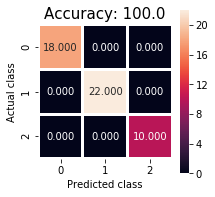

In [103]:
plt.figure(figsize=(3,3))
sns.heatmap(confusion_training, annot=True, fmt=".3f", linewidths=2, square = True);
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'Accuracy: {0}'.format(accuracy_training)
plt.title(all_sample_title, size = 15);

Now do the same thing to make confusion matrix for the testing data

In [104]:
#Convert the one-hot encoded matrix back to array of just classes
prediction_classes_testing = np.zeros(classes_testing.shape[0])
for i in range(0,classes_testing.shape[0]):
    for j in range(0,3):
        if prediction_testing[i,j] == np.max(prediction_testing[i,:]):
            prediction_classes_testing[i] = j+1
            
#Calculate confusion matrix
confusion_testing = np.zeros([3,3])
for i in range(0,classes_testing.shape[0]): 
    confusion_testing[int(classes_testing[i]-1),int(prediction_classes_testing[i] - 1)] +=1
confusion_testing     

array([[41.,  0.,  0.],
       [ 4., 45.,  0.],
       [ 0.,  1., 37.]])

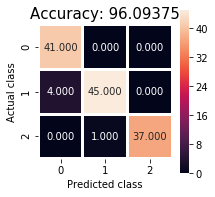

In [105]:
plt.figure(figsize=(3,3))
sns.heatmap(confusion_testing, annot=True, fmt=".3f", linewidths=2, square = True);
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'Accuracy: {0}'.format(accuracy_testing)
plt.title(all_sample_title, size = 15);

Since we can't plot a 14-dimensional graph, we thought if we chose three features with the heaviest weights, we might be able to find the features with the most influence in the classification. We chose three features as we can plot a 3-dimensional graph.
<br>We chose the features by taking absolute values of all elements in the weight matrix and the summing all along the rows. To choose the most influential features we chose, the largest values in the resulting array. 

In [121]:
W = np.sum(np.abs(W),axis=1)
W

array([1.51927071, 3.03221972, 0.73520657, 1.56466848, 1.61387962,
       1.4414802 , 0.9923955 , 1.5716679 , 0.65298324, 0.74802109,
       1.97767132, 1.56337454, 1.21723202, 2.708468  ])

The biggest weights correspond to the following features: 

1. Alcohol
2. Colour Intensity
3. Proline

Hence, we plot a graph with the features and colour the points according to the classes. After finding an appropriate rotation for the plot, we notice a clear separation between the classes on the graph.

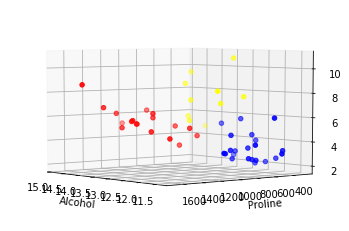

In [107]:
colours = []
for i in range(0,training_dataframe.shape[0]):
    if int(training_dataframe[i,0]) == 1:
        colours.append('red')
    elif int(training_dataframe[i,0]) == 2:
        colours.append('blue')
    else: 
        colours.append('yellow')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Alcohol')
ax.set_ylabel('Proline')
ax.set_zlabel('Colour Intensity')
ax.scatter(training_dataframe[:,1],training_dataframe[:,13],training_dataframe[:,10],c=colours,marker="o",picker=True)
ax.view_init(5,140)